Header

## Business Question

 For this project, you will be acting as a consultant for a fictional real-estate investment firm. The firm has asked you what seems like a simple question:

    What are the top 5 best zip codes for us to invest in?

This may seem like a simple question at first glance, but there's more than a little ambiguity here that you'll have to think through in order to provide a solid recommendation. Should your recommendation be focused on profit margins only? What about risk? What sort of time horizon are you predicting against? Your recommendation will need to detail your rationale and answer any sort of lingering questions like these in order to demonstrate how you define "best".

## Load the Data/Filtering for Chosen Zipcodes

import libraries

In [151]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

initial print

In [152]:
#load in data
df = pd.read_csv("data/zillow_data.csv")
#separate for only chicago data
df = df.loc[df['Metro'] == 'Chicago']
#df.info()

neighborhood dataset, tbd

In [153]:
# nh_df = pd.read_csv("data/neighborhood_data.csv")
# nh_df = nh_df.loc[nh_df['City'] == 'Chicago']
# nh_df.head(10)
#nh_df.info()

#I don't think I have a use for these but I'm not gonna throw em out until I know for sure
# city_zips = [60626, 60645, 60646, 60631, 60660, 
#              60659, 60640, 60625, 60630, 60656, 
#              60634, 60641, 60618, 60613, 60657, 
#              60707, 60639, 60647, 60614, 60666, 
#              60611, 60610, 60622, 60651, 60644, 
#              60624, 60612, 60607, 60661, 60606, 
#              60601, 60603, 60604, 60654, 60616, 
#              60608, 60623, 60632, 60609, 60653, 
#              60615, 60638, 60636, 60637, 60629, 
#              60652, 60620, 60619, 60643, 60655, 
#              60628, 60827, 60649, 60617, 60633, 
#              60619, 60621, 60661]

# print(len(city_zips))
# print(len(set(city_zips)))
# city_zips = list(set(city_zips))

## Preprocessing

adjusted get_datetimes function to work on different types of dataframes

In [154]:
def get_datetimes(df, startcol):
    return pd.to_datetime(df.columns.values[startcol:], format='%Y-%m')

get_datetimes(df, 7)
#get_datetimes(nh_df, 9)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

Feature engineering some lat/long baybee

Doing it up here so that I can drop or fill rows later without calling the geolocator again

In [155]:
import geopy
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent='project_4_time_series')

def get_lat(geolocator, locstring):
    location = geolocator.geocode('US ' + locstring)
    return location.latitude
def get_lon(geolocator, locstring):
    location = geolocator.geocode('US ' + locstring)
    return location.longitude

# df['latitude'] = df.apply(lambda x: get_lat(geolocator, str(x['RegionName'])), axis = 1)
# df['longitude'] = df.apply(lambda x: get_lon(geolocator, str(x['RegionName'])), axis = 1)

# df.to_csv('geocoded_data.csv')

df = pd.read_csv('geocoded_data.csv', index_col = 0)

df.head()

RegionID  RegionName     City State    Metro CountyName  SizeRank  \
0      84654       60657  Chicago    IL  Chicago       Cook         1   
3      84616       60614  Chicago    IL  Chicago       Cook         4   
7      84640       60640  Chicago    IL  Chicago       Cook         8   
16     84646       60647  Chicago    IL  Chicago       Cook        17   
19     84620       60618  Chicago    IL  Chicago       Cook        20   

     1996-04   1996-05   1996-06  ...  2017-09  2017-10  2017-11  2017-12  \
0   334200.0  335400.0  336500.0  ...  1007800  1009600  1013300  1018700   
3   498100.0  500900.0  503100.0  ...  1287400  1291500  1296600  1299000   
7   216500.0  216700.0  216900.0  ...   776100   774900   777900   777900   
16  122700.0  122800.0  122800.0  ...   464300   466500   467900   470600   
19  142600.0  143100.0  143400.0  ...   459900   459200   458700   457900   

    2018-01  2018-02  2018-03  2018-04   latitude  longitude  
0   1024400  1030700  1033800  1030600  41.939021 -87.656038  
3   1302700  1306400  1308500  1307000  41.922400 -87.650469  
7    778500   780500   782800   782800  41.972089 -87.663736  
16   474500   475100   472600   470200  41.919453 -87.699384  
19   457400   459000   462500   464300  41.944530 -87.700520  

[5 rows x 274 columns]

dealing with null values

In [156]:
#save indeces of rows with some missing values
missing_count = df.shape[1] - df.count(axis=1)
missing = missing_count[df.isna().any(axis=1)]
missing_indices = list(missing.index)

# nh_missing_count = nh_df.shape[1] - nh_df.count(axis=1)
# nh_missing = nh_missing_count[nh_df.isna().any(axis=1)]
# nh_missing_indices = list(nh_missing.index)

For now, I want to have two drop approaches for the data. I want to try running the data where I've simply dropped rows with null values, and also I want to try using data that's been back-filled. 

The larger dataset has less missing data overall, where it's concentrated in only 8 zip codes overall. It might be okay for this dataset to drop the rows that are missing lots of data. 
The neighborhood dataset has more missing data, so the filled dataset might be more useful. 

In [157]:
#versions of the DF where I dropped rows with null values
#df = df.dropna()
# df_nh = nh_df.dropna()

#versions of the DF where filled NaNs
#I first used ffill to fill NaNs with the most recent data. Then I went back and did a second pass of bfill to address the first Nan
df = df.fillna(method = 'ffill', axis = 1)
df.fillna(method = 'bfill', inplace = True, axis = 1)
# filled_nh = df.fillna(method = 'ffill', axis = 1)
# filled_nh = filled_nh.fillna(method = 'bfill', axis = 1)

#check for any more NaNs
# filled.shape[1] - filled.count(axis=1)
# filled_nh.shape[1] - filled_nh.count(axis=1)

In [158]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325 entries, 0 to 14604
Data columns (total 274 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionID    325 non-null    int64  
 1   RegionName  325 non-null    int64  
 2   City        325 non-null    object 
 3   State       325 non-null    object 
 4   Metro       325 non-null    object 
 5   CountyName  325 non-null    object 
 6   SizeRank    325 non-null    int64  
 7   1996-04     325 non-null    float64
 8   1996-05     325 non-null    float64
 9   1996-06     325 non-null    float64
 10  1996-07     325 non-null    float64
 11  1996-08     325 non-null    float64
 12  1996-09     325 non-null    float64
 13  1996-10     325 non-null    float64
 14  1996-11     325 non-null    float64
 15  1996-12     325 non-null    float64
 16  1997-01     325 non-null    float64
 17  1997-02     325 non-null    float64
 18  1997-03     325 non-null    float64
 19  1997-04     325 non-null  

regions
source : https://en.wikivoyage.org/wiki/Chicagoland

In [159]:
#region lists
city = ['Chicago']

north_shore = ['Evanston', 'Skokie', 'Highwood', 'Deerfield', 'Highland Park', 'Ravinia', 
               'Northbrook', 'Glencoe', 'Hubbard Woods', 'Winnetka', 'Northfield', 'Glenview', 
               'Indian Hill', 'Kenilworth', 'Wilmette', 'Lincoln Wood', 'Lake Bluff', 'Lake Forest']

nw_suburbs = ['Buffalo Grove', 'Arlington Heights', 'Palatine', 'Schaumburg', 'Libertyville', 
              'Lindenhurst', 'Lake Villa', 'Round Lake', 'Grayslake', 'Mundelein', 'Vernon Hills', 
              'Long Grove', 'Lincolnshire', 'Barrington Hills', 'Inverness', 'Wheeling', 'Mount Prospect', 
              'Morton Grove', 'Niles', 'Des Plaines', 'Park Ridge', 'Rosemont', 'Elk Grove Village', 'Roselle', 
              'Schiller Park', 'Itasca', 'Wood Dale']

far_north = ['Waukegan', 'Gurnee', 'Winthrop Harbor', 'Zion', 'Beach Park', 'North Chicago']

west_suburbs = ['Cicero', 'Franklin Park', 'Oak Park', 'Bloomingdale', 'Carol Stream', 'Addison', 'Lombard', 'Glen Ellyn', 
                'Wheaton', 'Villa Park', 'Elmhurst', 'River Forest', 'Oak Brook', 'Westchester', 'Hillside', 'River Forest', 
                'Forest Park', 'Berwyn', 'Riverside', 'Stickney', 'Brookfield', 'Western Springs', 'Lisle', 'Downers Grove', 
                'Woodridge', 'Darien', 'Westmont', 'Hinsdale', 'La Grange']

south_suburbs = ['Oak Lawn', 'Orland Park', 'Alsip', 'Orland Hills', 'Crestwood', 'Blue Island', 'Evergreen Park', 
                 'Harvey', 'Oak Forest', 'Olympia Fields', 'Dale', 'Dolton', 'Burnham', 'Tinley Park', 'Thornton', 
                 'Palos Heights', 'Palos Park', 'Markham', 'Frankfort', 'Country Club Hills', 'Hazel Crest', 'South Holland', 
                 'Palos Hills', 'Calumet City', 'Homewood', 'Matteson', 'Richton Park', 'Thornton', 'Lansing', 'Flossmoor', 
                 'Chicago Heights', 'Peotone', 'University Park', 'Lynwood', 'Steger', 'Park Forest', 'Sauk Village', 'Crete', 
                 'Beecher', 'Midlothian']

outer = ['Elgin', 'Bolingbrook', 'Aurora', 'Naperville', 'Antioch', 'Spring Grove', 'Fox Lake', 'Johnsburg', 
         'McHenry', 'Crystal Lake', 'Lake in the Hills', 'Algonquin', 'St. Charles', 'West Chicago', 'Warrenville', 
         'Geneva', 'Batavia', 'Romeoville', 'Crest Hill', 'Joliet', 'Lockport', 'Lemont', 'Goodings Groove', 'Homer Glen', 
         'New Lenox', 'Mokena', 'New Lenox']
region_key=['Chicago', 'North Shore', 'NW Suburbs', 'Far North', 'West Suburbs', 'South Suburbs', 'Outer Suburbs']

mp = {k: lbl
     for lst, lbl in [(city, '0'), (north_shore, '1'), (nw_suburbs, '2'), (far_north, '3'), (west_suburbs, '4'), (south_suburbs, '5'), (outer, '6')]
     for k in lst}

df['RegionCode'] = df['City'].map(mp)
df['RegionCode'].fillna('6', inplace = True)

strategy: melt here and then have option to use for visualizations

In [160]:
vars_list = ['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'latitude', 'longitude', "RegionCode"]
# vars_list_nh = nh_df.columns[:9]

def melt_data(df, vars_list):
    melted = pd.melt(df, 
                     id_vars=vars_list, 
                     var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted


In [161]:
melt = melt_data(df, vars_list)
#melt_nh = melt_data(df_nh, vars_list_nh)

#cheque

print('Melt Check')
print("Before: {} , After: {}".format(df.shape, melt.shape))
# print('Melt Check')
# print("Before: {} , After: {}".format(cleaned_nh.shape, melt_nh.shape))

Melt Check
Before: (325, 275) , After: (86125, 12)


# Step 3: EDA and Visualization

In [162]:
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

# plt.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [163]:
melt.head()

RegionID  RegionName     City State    Metro CountyName  SizeRank  \
0     84654       60657  Chicago    IL  Chicago       Cook         1   
1     84616       60614  Chicago    IL  Chicago       Cook         4   
2     84640       60640  Chicago    IL  Chicago       Cook         8   
3     84646       60647  Chicago    IL  Chicago       Cook        17   
4     84620       60618  Chicago    IL  Chicago       Cook        20   

    latitude  longitude RegionCode       time     value  
0  41.939021 -87.656038          0 1996-04-01  334200.0  
1  41.922400 -87.650469          0 1996-04-01  498100.0  
2  41.972089 -87.663736          0 1996-04-01  216500.0  
3  41.919453 -87.699384          0 1996-04-01  122700.0  
4  41.944530 -87.700520          0 1996-04-01  142600.0

In [164]:
info_cols = list(melt.columns[:10])
info_cols

# for col in info_cols:
#     print(col)
#     print(df[col].describe())

['RegionID',
 'RegionName',
 'City',
 'State',
 'Metro',
 'CountyName',
 'SizeRank',
 'latitude',
 'longitude',
 'RegionCode']

In [165]:
city_df = df.loc[df['City'] == 'Chicago']
city_df.info()
for col in info_cols:
    print(col)
    print(city_df[col].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 0 to 7863
Columns: 275 entries, RegionID to RegionCode
dtypes: float64(221), int64(49), object(5)
memory usage: 88.4+ KB
RegionID
count        41.000000
mean      92317.829268
std       49207.238957
min       84607.000000
25%       84620.000000
50%       84634.000000
75%       84647.000000
max      399713.000000
Name: RegionID, dtype: float64
RegionName
count       41.000000
mean     60633.097561
std         16.887577
min      60605.000000
25%      60618.000000
50%      60633.000000
75%      60647.000000
max      60660.000000
Name: RegionName, dtype: float64
City
count          41
unique          1
top       Chicago
freq           41
Name: City, dtype: object
State
count     41
unique     1
top       IL
freq      41
Name: State, dtype: object
Metro
count          41
unique          1
top       Chicago
freq           41
Name: Metro, dtype: object
CountyName
count       41
unique       1
top       Cook
freq        41
Name: Cou

In [166]:
def isolate_zip(data, zip_code):
    section = data.loc[data['RegionName'] == zip_code]

    section = melt_data(section, vars_list)
    x = pd.DatetimeIndex(section['time'], freq='infer')
    return pd.Series(section['value'].to_numpy(), 
                         index=x)
isolate_zip(df, 60640)

time
1996-04-01    216500.0
1996-05-01    216700.0
1996-06-01    216900.0
1996-07-01    217000.0
1996-08-01    217100.0
                ...   
2017-12-01    777900.0
2018-01-01    778500.0
2018-02-01    780500.0
2018-03-01    782800.0
2018-04-01    782800.0
Freq: MS, Length: 265, dtype: float64

In [167]:
#aggregate data
def isolate_subregion(data, subregion_id):
    subregion = data.groupby(by=['RegionCode']).mean()
    subregion = subregion.iloc[[subregion_id]]
    subregion_vars = ['RegionID', 'RegionName', 'SizeRank', 'latitude', 'longitude']

    subregion = melt_data(subregion, subregion_vars)
    x = pd.DatetimeIndex(subregion['time'], freq='infer')
    return pd.Series(subregion['value'].to_numpy(), 
                         index=x)
isolate_subregion(df, 0)

time
1996-04-01    172448.926829
1996-05-01    172900.146341
1996-06-01    173173.317073
1996-07-01    173231.853659
1996-08-01    173109.902439
                  ...      
2017-12-01    474153.658537
2018-01-01    476026.829268
2018-02-01    477909.756098
2018-03-01    478475.609756
2018-04-01    477292.682927
Freq: MS, Length: 265, dtype: float64

In [168]:
def plot_rolling(series, titlestring):
    #stationary
    y = series.values

    x = series.index

    roll_mean = series.rolling(window=8, center=False).mean()
    roll_std = series.rolling(window=8, center=False).std()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=y, line=go.scatter.Line(color='blue'), name='Original'))
    fig.add_trace(go.Scatter(x=x, y=roll_mean, line=go.scatter.Line(color='red'), name='Rolling Mean'))
    fig.add_trace(go.Scatter(x=x, y=roll_std, line=go.scatter.Line(color='black'), name='Rolling Std'))

    title = titlestring + " Rolling Mean and Standard Deviation"

    #title
    fig.update_layout(title_text=title)

    # Set x-axis title
    fig.update_xaxes(title_text="Year")

    # Set y-axes titles
    fig.update_yaxes(title_text="Aggregate Housing Cost")
    fig.show()


plot_rolling(isolate_zip(df, 60640), '60640')

In [169]:
fig = go.Figure()

#iterate through each subregion
for i in range(0,7):
    ser = isolate_subregion(df, i)
    y = ser.values
    x = ser.index
    fig.add_trace(go.Scatter(x=x, y=y, name=region_key[i]))
#title
fig.update_layout(title_text='Chicago Housing Trends by Region')

# Set x-axis title
fig.update_xaxes(title_text="Year")

# Set y-axes titles
fig.update_yaxes(title_text="Aggregate Housing Cost")
fig.show()

In [170]:
for subregion in range(0,7):
    plot_rolling(isolate_subregion(df, subregion), region_key[subregion])


In [171]:
#seasonality
for i in range(0, 7):
    fig = go.Figure()
    for year in range(1996, 2019):
        ser = isolate_subregion(df, i).loc[str(year)]

        y = ser.values
        x = ser.index.month
        fig.add_trace(go.Scatter(x=x, y=y, name=str(year)))
    #title
    fig.update_layout(title_text= region_key[i] + ' Housing Trends by Year')

    # Set x-axis title
    fig.update_xaxes(title_text="Month")

    # Set y-axes titles
    fig.update_yaxes(title_text= "Aggregate Home Price in USD")
    fig.show()


In [172]:
# from urllib.request import urlopen
# import json
# with urlopen('https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/il_illinois_zip_codes_geo.min.json') as response:
#     zip_codes = json.load(response)
    
# fig = px.choropleth_mapbox(df, geojson=zip_codes, locations='RegionName', color='2018-04',
#                            color_continuous_scale="Viridis",
#                            featureidkey='properties.ZCTA5CE10',
#                            range_color=(50000,700000),
#                            mapbox_style="carto-positron",
#                            zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
#                            opacity=0.5,
#                            labels={'1996-04':'Home Values, April 1996'}
#                           )
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

In [173]:
#autocorrelation
pd.plotting.autocorrelation_plot(isolate_zip(df, 60640))

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

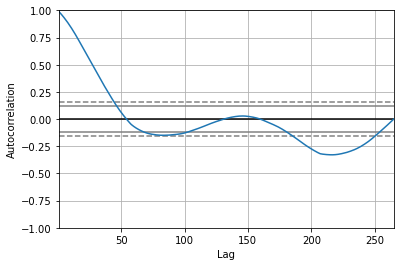

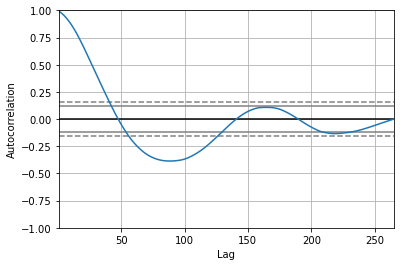

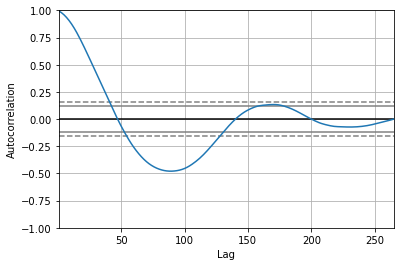

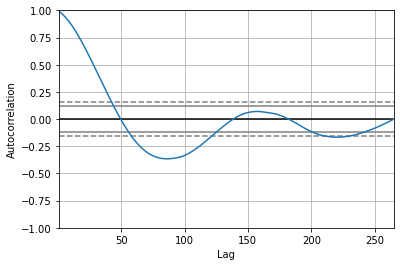

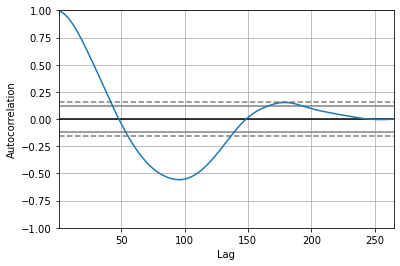

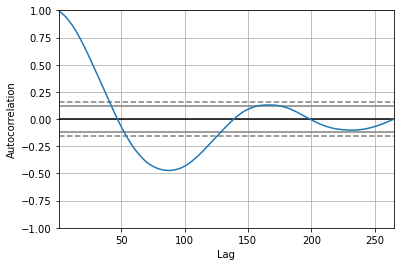

In [176]:
for i in range(0,7):
    fig = plt.figure()
    fig = pd.plotting.autocorrelation_plot(isolate_subregion(df, i))

In [177]:
melt.head()

RegionID  RegionName     City State    Metro CountyName  SizeRank  \
0     84654       60657  Chicago    IL  Chicago       Cook         1   
1     84616       60614  Chicago    IL  Chicago       Cook         4   
2     84640       60640  Chicago    IL  Chicago       Cook         8   
3     84646       60647  Chicago    IL  Chicago       Cook        17   
4     84620       60618  Chicago    IL  Chicago       Cook        20   

    latitude  longitude RegionCode       time     value  
0  41.939021 -87.656038          0 1996-04-01  334200.0  
1  41.922400 -87.650469          0 1996-04-01  498100.0  
2  41.972089 -87.663736          0 1996-04-01  216500.0  
3  41.919453 -87.699384          0 1996-04-01  122700.0  
4  41.944530 -87.700520          0 1996-04-01  142600.0

## Processing

In [178]:
temp = isolate_zip(df, 60640)

SPLIT = int(temp.shape[0]*0.8)
train, test = temp[:SPLIT], temp[SPLIT:]

#check
train.shape, test.shape

#train

#test train split
train = pd.concat([df.iloc[:, 0:7], df.iloc[:,272:275], df.iloc[:,7:219]], axis=1)
test = pd.concat([df.iloc[:, 0:7], df.iloc[:,272:275], df.iloc[:,219:272]], axis=1)

((212,), (53,))

## Modeling

### ARIMA

In [180]:
isolate_zip(train, 60640)

time
1996-04-01    216500.0
1996-05-01    216700.0
1996-06-01    216900.0
1996-07-01    217000.0
1996-08-01    217100.0
                ...   
2013-07-01    588500.0
2013-08-01    591400.0
2013-09-01    591700.0
2013-10-01    591800.0
2013-11-01    589500.0
Freq: MS, Length: 212, dtype: float64

In [181]:
#model ARIMA with one zip
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(isolate_zip(train, 60640), order=(1, 1, 1)).fit()
arima_model.summary()

C:\Users\carly\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  212
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2048.935
Date:                Sun, 16 May 2021   AIC                           4103.870
Time:                        23:17:19   BIC                           4113.926
Sample:                    04-01-1996   HQIC                          4107.935
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9857      0.005    207.879      0.000       0.976       0.995
ma.L1         -0.9699      0.007   -134.541      0.000      -0.984      -0.956
sigma2      1.434e+07   1.17e-11   1.22e+18      0.000    1.43e+07    1.43e+07
===================================================================================
Ljung-Box (L1) (Q):                 163.46   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.00   Prob(JB):                         0.58
Heteroskedasticity (H):               3.92   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.33e+33. Standard errors may be unstable.
"""

In [196]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

ans = []
for comb in pdq:
    try:
        mod = ARIMA(isolate_zip(train, 60640),
                    order=comb,
                    enforce_stationarity=False,
                    enforce_invertibility=False)

        output = mod.fit()
        ans.append([comb, output.aic])
        print('ARIMA {} : AIC Calculated ={}'.format(comb, output.aic))
    except ValueError:
        pass

ARIMA (0, 0, 0) : AIC Calculated =6585.670594332129
ARIMA (0, 0, 1) : AIC Calculated =5482.275855536349
ARIMA (0, 0, 2) : AIC Calculated =5411.526753014446
ARIMA (0, 1, 0) : AIC Calculated =4158.853925001928
ARIMA (0, 1, 1) : AIC Calculated =3949.0593516685317
ARIMA (0, 1, 2) : AIC Calculated =3682.044644867847
ARIMA (0, 2, 0) : AIC Calculated =3763.5355229958977
ARIMA (0, 2, 1) : AIC Calculated =3700.1340583764677
ARIMA (0, 2, 2) : AIC Calculated =3650.6897288725986
ARIMA (1, 0, 0) : AIC Calculated =4166.087243151394
ARIMA (1, 0, 1) : AIC Calculated =3959.906787745662
ARIMA (1, 0, 2) : AIC Calculated =3693.8259852458923
ARIMA (1, 1, 0) : AIC Calculated =3773.7696179709883
ARIMA (1, 1, 1) : AIC Calculated =3728.9642531003237
ARIMA (1, 1, 2) : AIC Calculated =3649.7935698066785
ARIMA (1, 2, 0) : AIC Calculated =3732.6207453251845
ARIMA (1, 2, 1) : AIC Calculated =3697.36830078812
ARIMA (1, 2, 2) : AIC Calculated =3647.8060176966183
ARIMA (2, 0, 0) : AIC Calculated =3774.2278010443406
AR

In [197]:
# train_melt = melt_data(train, vars_list)
# train_melt

# x = pd.DatetimeIndex(train_melt['time'], freq='infer')
# train_series = pd.Series(train_melt['value'].to_numpy(), index=x)
# train_series

# arima_model = ARIMA(train_series, order=(1, 1, 1)).fit()
# arima_model.summary()

In [200]:
output = ARIMA(isolate_zip(train, 60640), order=(2, 2, 2),
              enforce_stationarity=False,
              enforce_invertibility=False).fit()
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  212
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1804.425
Date:                Mon, 17 May 2021   AIC                           3618.850
Time:                        01:29:14   BIC                           3635.513
Sample:                    04-01-1996   HQIC                          3625.588
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5328      0.069      7.685      0.000       0.397       0.669
ar.L2         -0.5581      0.044    -12.773      0.000      -0.644      -0.472
ma.L1          0.1109      0.087      1.268      0.205      -0.061       0.282
ma.L2          0.0053      0.061      0.086      0.931      -0.115       0.126
sigma2      2.189e+06   1.21e+05     18.065      0.000    1.95e+06    2.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               382.69
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):             103.66   Skew:                             0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

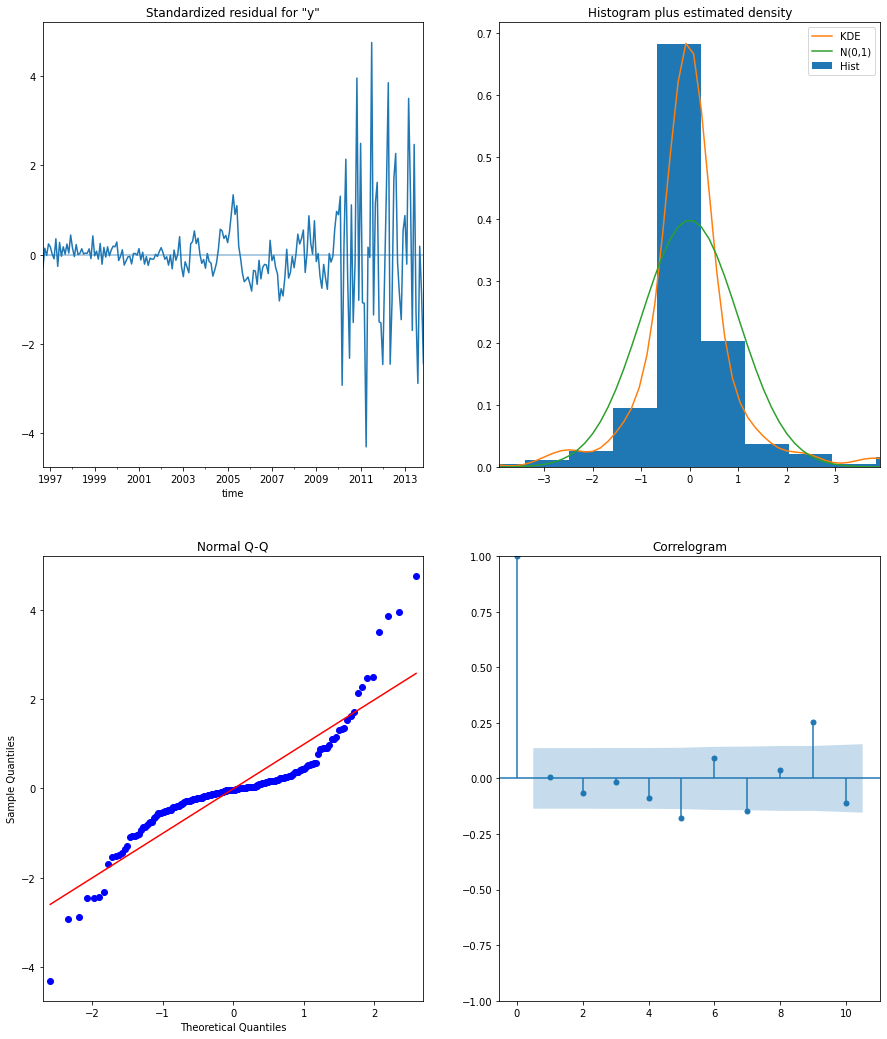

In [202]:
output.plot_diagnostics(figsize=(15,18))
plt.show()

In [211]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2013-11-01'), end= pd.to_datetime('2018-04-01'), dynamic=False)
pred_conf = pred.conf_int()

In [215]:

ax = isolate_zip(df, 60640).plot(label='actual')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Costs')
plt.legend()

plt.show()

In [216]:
# Get the real and predicted values
forecasted = pred.predicted_mean
actual = isolate_zip(test, 60640)

# Compute the mean square error
mse = ((forecasted - actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 46384671855.78


In [224]:
temp = isolate_zip(df, 60640)['2009-01-01':]

SPLIT = int(temp.shape[0]*0.8)
train, test = temp[:SPLIT], temp[SPLIT:]

#check
train.shape, test.shape

#train

#test train split
train = pd.concat([df.iloc[:, 0:7], df.iloc[:,272:275], df.iloc[:,160:249]], axis=1)
test = pd.concat([df.iloc[:, 0:7], df.iloc[:,272:275], df.iloc[:,249:272]], axis=1)

In [225]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

ans = []
for comb in pdq:
    try:
        mod = ARIMA(isolate_zip(train, 60640),
                    order=comb,
                    enforce_stationarity=False,
                    enforce_invertibility=False)

        output = mod.fit()
        ans.append([comb, output.aic])
        print('ARIMA {} : AIC Calculated ={}'.format(comb, output.aic))
    except ValueError:
        pass

ARIMA (0, 0, 0) : AIC Calculated =2478.2016797303872
ARIMA (0, 0, 1) : AIC Calculated =2085.0253269215323
ARIMA (0, 0, 2) : AIC Calculated =2047.7911265117502
ARIMA (0, 1, 0) : AIC Calculated =1747.7365812850292
ARIMA (0, 1, 1) : AIC Calculated =1647.5546124569232
ARIMA (0, 1, 2) : AIC Calculated =1580.3857076940005
ARIMA (0, 2, 0) : AIC Calculated =1639.7764531396044
ARIMA (0, 2, 1) : AIC Calculated =1612.1460866790374
ARIMA (0, 2, 2) : AIC Calculated =1582.415569990788
ARIMA (1, 0, 0) : AIC Calculated =1769.2016748235676
ARIMA (1, 0, 1) : AIC Calculated =1669.9290384951257
ARIMA (1, 0, 2) : AIC Calculated =1607.4740952928214
ARIMA (1, 1, 0) : AIC Calculated =1651.7761399768463
ARIMA (1, 1, 1) : AIC Calculated =1637.4397822252288
ARIMA (1, 1, 2) : AIC Calculated =1589.3736196121515
ARIMA (1, 2, 0) : AIC Calculated =1630.3238581235846
ARIMA (1, 2, 1) : AIC Calculated =1610.5470438837663
ARIMA (1, 2, 2) : AIC Calculated =1581.1594307197954
ARIMA (2, 0, 0) : AIC Calculated =1654.51002650

In [226]:
output = ARIMA(isolate_zip(train, 60640), order=(2, 2, 2),
              enforce_stationarity=False,
              enforce_invertibility=False).fit()
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   89
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -779.547
Date:                Mon, 17 May 2021   AIC                           1569.095
Time:                        02:04:19   BIC                           1581.249
Sample:                    01-01-2009   HQIC                          1573.981
                         - 05-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4851      0.191      2.539      0.011       0.111       0.860
ar.L2         -0.5407      0.117     -4.635      0.000      -0.769      -0.312
ma.L1          0.0932      0.217      0.429      0.668      -0.333       0.519
ma.L2          0.0092      0.065      0.141      0.888      -0.119       0.137
sigma2      6.843e+06   1.25e+06      5.471      0.000    4.39e+06    9.29e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.77
Prob(Q):                              0.88   Prob(JB):                         0.68
Heteroskedasticity (H):               0.74   Skew:                             0.22
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

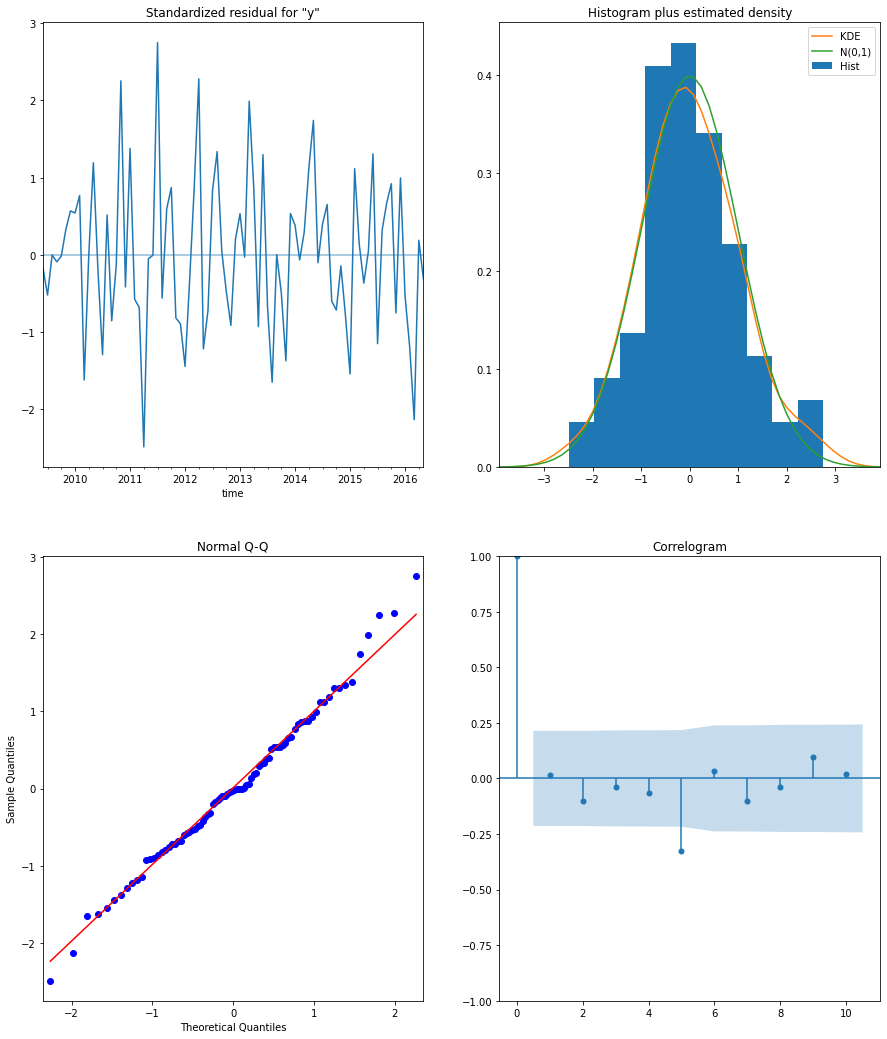

In [227]:
output.plot_diagnostics(figsize=(15,18))
plt.show()

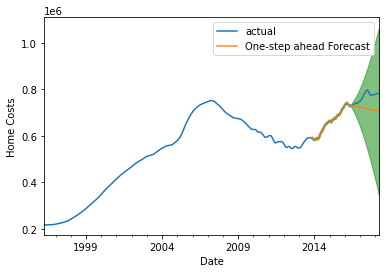

In [228]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2013-11-01'), end= pd.to_datetime('2018-04-01'), dynamic=False)
pred_conf = pred.conf_int()


ax = isolate_zip(df, 60640).plot(label='actual')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Costs')
plt.legend()

plt.show()

### Evaluating

## Conclusions